# Prima prova Laboratorio
Vogliamo studiare la caratteristica di 2 diodi: 1 diodo al Silicio, 1 diodo al Germanio.

Il circuito utilizzato è:

 (Aggiungere immagine)

## Calibrazione oscilloscopio-multimetro
Vogliamo fittare il potenziale misurate e il potenziale misurato dal multimetro e quello misurato dall'oscilloscopio e verificare che sia una retta passante
per l'origine, cioè voglio $ a \approx 0 $

La Funzione del fit sarà:
$$
V_{oscilloscopio} = a + b \cdot V_{multimetro}
$$

a =  0.067 ± 0.21826
b =  0.975 ± 0.10104


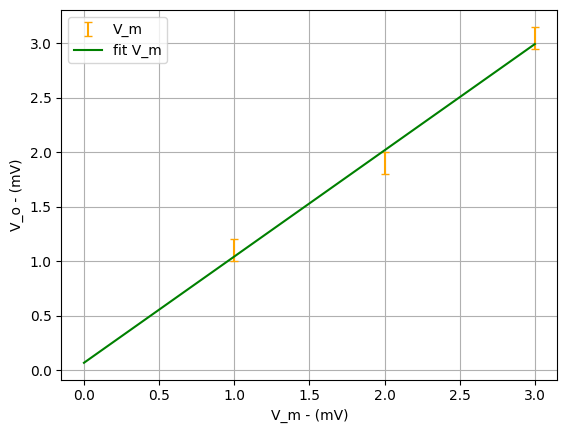

In [34]:
import numpy as np
from matplotlib import pyplot as plt  # this is the traditional method
from statistics import stdev
from scipy.optimize import curve_fit  # import method used here

#we define the function for the linear fit
def linear_fit(x, a, b):
    return a + b*x


file_to_analyze = "Calibrazione"
Data = np.loadtxt("Dati/" + file_to_analyze, float, skiprows=1)
V_m = Data[:, 0]
V_o = Data[:, 1]
error_V_o = Data[:, 2]

# initial guess
a = 0
b = 1
initial_guess_cal = np.array([a,b])

#fit the data
fit_cal, cov_cal = curve_fit(linear_fit, V_m, V_o, sigma=error_V_o, p0=initial_guess_cal)

error_cal = np.sqrt(np.diag(cov_cal))

# print the results
print('a = ', '{:.3f}'.format(fit_cal[0]), '±', '{:.5f}'.format(error_cal[0]))
print('b = ', '{:.3f}'.format(fit_cal[1]), '±', '{:.5f}'.format(error_cal[1]))

#plot the fits
plt.xlabel("V_m - (mV)")
plt.ylabel("V_o - (mV)")

simul_V_m = np.linspace(0, V_m[len(V_m) - 1], 100)
simul_V_o = linear_fit(simul_V_m, fit_cal[0], fit_cal[1])

plt.errorbar(V_m, V_o, error_V_o, linestyle="none", color="orange", capsize=3, capthick=1, label="V_m") #data with error
plt.errorbar(simul_V_m, simul_V_o, label="fit V_m", color="green") #fit

plt.legend(loc='upper left')

plt.grid(True)
plt.show()


## Caratteristica I-V
Vogliamo studiare le caratteristiche dei 2 diodi.
La caratteristica di un diodo è:
$$
I = I_{0}( \exp{\frac{V_D}{\eta V_T}} - 1 )
$$

In [35]:
def f_I(V_D,I_0, eta_V_T):
    return I_0*(np.exp(V_D/eta_V_T) - 1)

Per fare il fit quindi possiamo linearizzarla ed otteniamo:
$$
V_D = -\eta V_T \log{I_{0}} + \eta V_T \log{I}
$$

analogo a: $Y = a + bX$ con $a = -\eta V_T \log{I_{0}} $ e $b = \eta V_T $

### Silicio
Facciamo il fit e calcoliamo i parametri

In [36]:
file_to_analyze = "Silicio"
Data = np.loadtxt("Dati/" + file_to_analyze, float, skiprows=1)
I_Si = Data[:, 0]
V_Si = Data[:, 1]
error_Si = Data[:, 2] # it's the error on the V

# initial guess
a_Si = 1e-6
b_Si = 50
initial_guess_Si = np.array([a,b])

#fit the data
fit_Si, cov_Si = curve_fit(linear_fit, I_Si, V_Si, sigma=error_Si, p0=initial_guess_Si)

error_Si = np.sqrt(np.diag(cov_Si))

# print the fit results
print('a_Si = ', '{:.3f}'.format(fit_Si[0]), '±', '{:.5f}'.format(error_Si[0]))
print('b_Si = ', '{:.3f}'.format(fit_Si[1]), '±', '{:.5f}'.format(error_Si[1]))

a_Si =  0.000 ± inf
b_Si =  1.000 ± inf


Calcoliamo i parametri del diodo, coi relativi errori. In particolare l'errore su $I_0$ si calcola come:
$$
\delta I_0 = \frac{I_0}{b} \sqrt{(\delta a)^2 + \frac{a^2}{b^2} (\delta b)^2 + 2\frac{a}{b}\delta ab}
$$

In [37]:
#evaluate the results
eta_V_T_Si = fit_Si[1]
eta_V_T_error_Si = error_Si[1]
I_0_Si = np.exp(-fit_Si[0]/fit_Si[1])
I_0_error_Si = (I_0_Si/fit_Si[1])*np.sqrt(error_Si[0]**2 + ((a**2)/(b**2))*error_Si[1]**2 + 2*(fit_Si[0]/fit_Si[1])*cov_Si[0][1])

#print the results
print('eta V_T = ', '{:.3f}'.format(eta_V_T_Si), '±', '{:.5f}'.format(eta_V_T_error_Si))
print('I_0 = ', '{:.3f}'.format(I_0_Si), '±', '{:.5f}'.format(I_0_error_Si))

eta V_T =  1.000 ± inf
I_0 =  1.000 ± nan


C:\Users\filim\AppData\Local\Temp\ipykernel_12712\3979632436.py:5: RuntimeWarning: invalid value encountered in double_scalars
  I_0_error_Si = (I_0_Si/fit_Si[1])*np.sqrt(error_Si[0]**2 + ((a**2)/(b**2))*error_Si[1]**2 + 2*(fit_Si[0]/fit_Si[1])*cov_Si[0][1])


Facciamo i grafici dei fit, sia quello esponenziale che quello in semiscala logaritmica

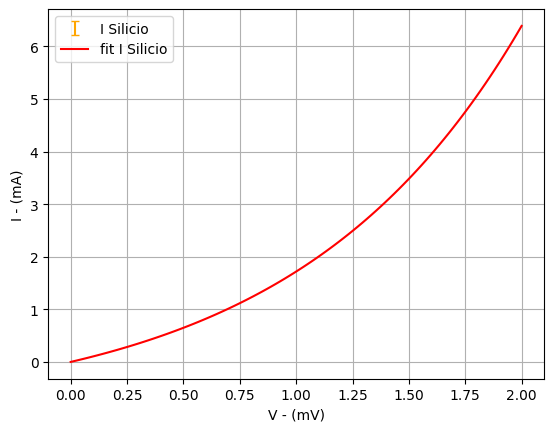

In [38]:
simul_V_Si = np.linspace(0, V_Si[len(V_Si) - 1], 100)
simul_I_Si = f_I(simul_V_Si, I_0_Si, eta_V_T_Si)

#normal graph
plt.xlabel("V - (mV)")
plt.ylabel("I - (mA)")

plt.errorbar(V_Si, I_Si, error_Si, linestyle="none", color="orange", capsize=3, capthick=1, label="I Silicio") # data with error
plt.errorbar(simul_V_Si, simul_I_Si, label="fit I Silicio", color="red") #fit

plt.legend(loc='upper left')

plt.grid(True)
plt.show()

C:\Users\filim\AppData\Local\Temp\ipykernel_12712\1246862575.py:6: RuntimeWarning: divide by zero encountered in log
  plt.errorbar(simul_V_Si, np.log(simul_I_Si), label="fit I Silicio", color="red") #fit


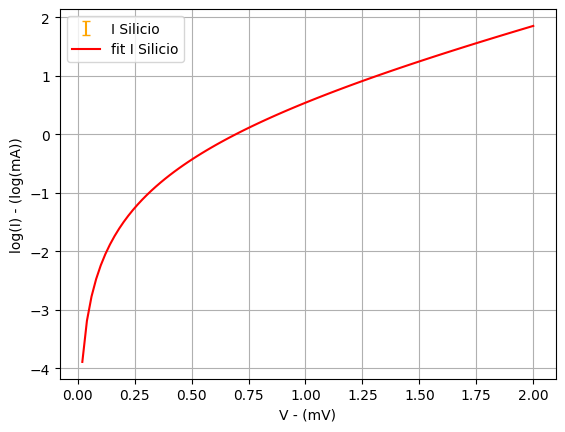

In [39]:
#semilogarithmic graph
plt.xlabel("V - (mV)")
plt.ylabel("log(I) - (log(mA))")

plt.errorbar(V_Si, np.log(I_Si), np.log(error_Si), linestyle="none", color="orange", capsize=3, capthick=1, label="I Silicio") # data with error
plt.errorbar(simul_V_Si, np.log(simul_I_Si), label="fit I Silicio", color="red") #fit

plt.legend(loc='upper left')

plt.grid(True)
plt.show()

### Germanio
Analogamente come abbiamo fatto come con il silicio

In [40]:
file_to_analyze = "Germanio"
Data = np.loadtxt("Dati/" + file_to_analyze, float, skiprows=1)
I_Ge = Data[:, 0]
V_Ge = Data[:, 1]
error_Ge = Data[:, 2] # it's the error on the V

# initial guess
a_Ge = 1e-6
b_Ge = 50
initial_guess_Ge = np.array([a,b])

#fit the data
fit_Ge, cov_Ge = curve_fit(linear_fit, I_Ge, V_Ge, sigma=error_Ge, p0=initial_guess_Ge)

error_Ge = np.sqrt(np.diag(cov_Ge))

# print the fit results
print('a_Ge = ', '{:.3f}'.format(fit_Ge[0]), '±', '{:.5f}'.format(error_Ge[0]))
print('b_Ge = ', '{:.3f}'.format(fit_Ge[1]), '±', '{:.5f}'.format(error_Ge[1]))

a_Ge =  -3.000 ± inf
b_Ge =  4.000 ± inf


Calcoliamo i parametri

In [41]:
#evaluate the results
eta_V_T_Ge = fit_Ge[1]
eta_V_T_error_Ge = error_Ge[1]
I_0_Ge = np.exp(-fit_Ge[0]/fit_Ge[1])
I_0_error_Ge = (I_0_Si/fit_Ge[1])*np.sqrt(error_Ge[0]**2 + ((a**2)/(b**2))*error_Ge[1]**2 + 2*(fit_Ge[0]/fit_Ge[1])*cov_Ge[0][1])

#print the results
print('eta V_T = ', '{:.3f}'.format(eta_V_T_Ge), '±', '{:.5f}'.format(eta_V_T_error_Ge))
print('I_0 = ', '{:.3f}'.format(I_0_Ge), '±', '{:.5f}'.format(I_0_error_Ge))

eta V_T =  4.000 ± inf
I_0 =  2.117 ± nan


C:\Users\filim\AppData\Local\Temp\ipykernel_12712\94897452.py:5: RuntimeWarning: invalid value encountered in double_scalars
  I_0_error_Ge = (I_0_Si/fit_Ge[1])*np.sqrt(error_Ge[0]**2 + ((a**2)/(b**2))*error_Ge[1]**2 + 2*(fit_Ge[0]/fit_Ge[1])*cov_Ge[0][1])


Facciamo i grafici dei fit, sia quello esponenziale che quello in semiscala logaritmica

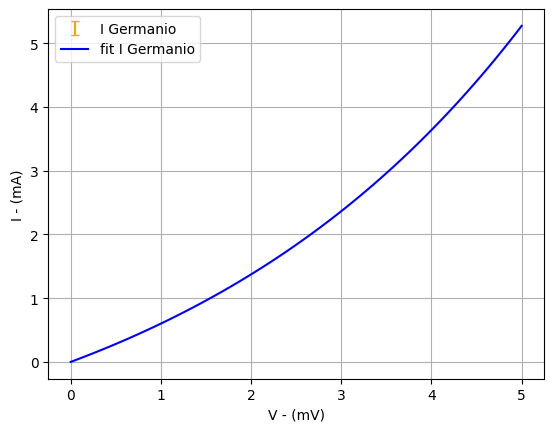

In [42]:
simul_V_Ge = np.linspace(0, V_Ge[len(V_Ge) - 1], 100)
simul_I_Ge = f_I(simul_V_Ge, I_0_Ge, eta_V_T_Ge)

#normal graph
plt.xlabel("V - (mV)")
plt.ylabel("I - (mA)")

plt.errorbar(V_Ge, I_Ge, error_Ge, linestyle="none", color="orange", capsize=3, capthick=1, label="I Germanio") # data with error
plt.errorbar(simul_V_Ge, simul_I_Ge, label="fit I Germanio", color="blue") #fit

plt.legend(loc='upper left')

plt.grid(True)
plt.show()

C:\Users\filim\AppData\Local\Temp\ipykernel_12712\1406009393.py:6: RuntimeWarning: divide by zero encountered in log
  plt.errorbar(simul_V_Ge, np.log(simul_I_Ge), label="fit I Germanio", color="blue") #fit


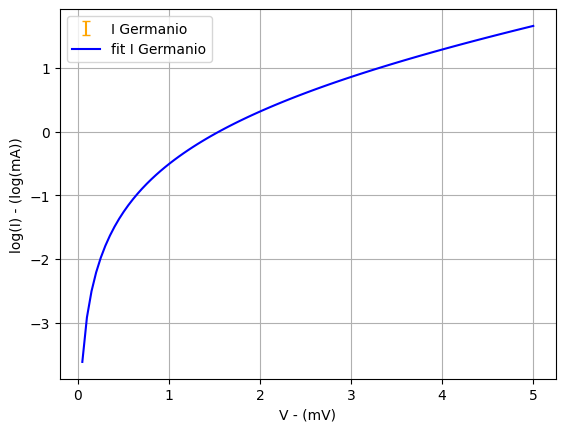

In [43]:
#semilogarithmic graph
plt.xlabel("V - (mV)")
plt.ylabel("log(I) - (log(mA))")

plt.errorbar(V_Ge, np.log(I_Ge), np.log(error_Ge), linestyle="none", color="orange", capsize=3, capthick=1, label="I Germanio") # data with error
plt.errorbar(simul_V_Ge, np.log(simul_I_Ge), label="fit I Germanio", color="blue") #fit

plt.legend(loc='upper left')

plt.grid(True)
plt.show()

### Confronto caratteristiche
Confrontiamo i grafici delle caratteristiche dei 2 diodi

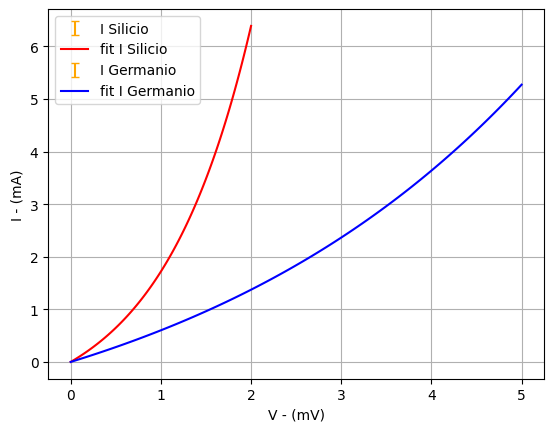

In [44]:
plt.xlabel("V - (mV)")
plt.ylabel("I - (mA)")

plt.errorbar(V_Si, I_Si, error_Si, linestyle="none", color="orange", capsize=3, capthick=1, label="I Silicio") # data with error
plt.errorbar(simul_V_Si, simul_I_Si, label="fit I Silicio", color="red") #fit


plt.errorbar(V_Ge, I_Ge, error_Ge, linestyle="none", color="orange", capsize=3, capthick=1, label="I Germanio") # data with error
plt.errorbar(simul_V_Ge, simul_I_Ge, label="fit I Germanio", color="blue") #fit


plt.legend(loc='upper left')

plt.grid(True)
plt.show()